### Import Packages, Data and Initial Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import datetime
import itertools
import statsmodels.api as sm
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.backends.backend_pdf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sn.set()
data = pd.read_csv(r'C:\Users\nickp\Desktop\data science\births.csv')
print("Dataset Length: {}".format(len(data)))
data.head()

Dataset Length: 1409


,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie,MomRace
0,1,1,32,40,1,38,0,111,0,0,white
1,1,2,32,37,1,34,0,116,0,0,white
2,1,1,27,39,1,12,0,138,0,0,white
3,1,1,27,39,1,15,0,136,0,0,white
4,1,1,25,39,1,32,0,121,0,0,white


In [3]:
#Dictionaries for mapping
sex = {1: 'male',
       2: 'female'}

marital_status = {1: 'married',
                 2: 'not married'}

smoker = {1: 'yes',
         0: 'no'}

#premature defined as less than 36 weeks
premie = {0: 'no',
         1: 'yes'}

In [4]:
#map dictionaries to columns
data['Gender'] = data['Sex'].map(sex)
data['Marital Status'] = data['Marital'].map(marital_status)
data['Smoker'] = data['Smoke'].map(smoker)
data['Premie Baby'] = data['Premie'].map(premie)

In [5]:
lbs = 16

#division function
def division(df, col1, n, newcol):
    df[newcol] = df[col1] / n
    return df

data = division(data, 'BirthWeightOz', lbs, 'Birth Weight')

### Exploratory Analysis

In [6]:
#check null values
data.isnull().sum()

Plural            0
Sex               0
Mom Age           0
Weeks             0
Marital           0
Weight Gained     0
Smoke             0
BirthWeightOz     0
Low               0
Premie            0
MomRace           0
Gender            0
Marital Status    0
Smoker            0
Premie Baby       0
Birth Weight      0
dtype: int64

In [7]:
#summary statistics
data.describe()

,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie,Birth Weight
count,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.00000,1409.000000
mean,1.036196,1.488999,26.792761,38.649397,1.344925,30.589780,0.146203,116.440738,0.084457,0.12846,7.277546
std,0.201475,0.500056,6.089151,2.654167,0.475513,13.875535,0.353435,22.125534,0.278171,0.33472,1.382846
min,1.000000,1.000000,13.000000,22.000000,1.000000,0.000000,0.000000,12.000000,0.000000,0.00000,0.750000
25%,1.000000,1.000000,22.000000,38.000000,1.000000,20.000000,0.000000,106.000000,0.000000,0.00000,6.625000
50%,1.000000,1.000000,26.000000,39.000000,1.000000,30.000000,0.000000,118.000000,0.000000,0.00000,7.375000
75%,1.000000,2.000000,31.000000,40.000000,2.000000,40.000000,0.000000,130.000000,0.000000,0.00000,8.125000
max,3.000000,2.000000,43.000000,45.000000,2.000000,95.000000,1.000000,181.000000,1.000000,1.00000,11.312500


In [8]:
#groupby function
def groupby(df, group_list, calc_column, calculations):
    group = df.groupby(group_list).agg({calc_column: calculations}).reset_index()
    group.columns = ['_'.join(col) for col in group.columns]
    group.columns = [col.strip(punctuation) for col in group.columns]
    group_count = df.groupby(group_list)[calc_column].count().reset_index()
    group_count.columns = [col if col in group_list else 'count_'+col for col in group_count.columns]
    final = pd.merge(group, group_count, on=group_list, how='left')
    return final

In [9]:
#All combinations data analysis algorithm
def combinations_calculations_algorithm(df, groupby_list, calc_column, calculations, groupby_function, n):
    start = datetime.datetime.now()
    
    output_df = pd.DataFrame()
    
    for L in range(0, len(groupby_list)+1):
        for subset in itertools.combinations(groupby_list, L):
            df2 = df.copy()
            
            if len(groupby_list) > n:
                df2 = df2[groupby_list]
                df2.drop_duplicates(groupby_list, keep='first', inplace=True)
                
                for element in calc_column:
                    df_groupby = groupby_function(df, groupby_list, element, calculations)
                    df2 = pd.merge(df2, df_groupby, on=groupby_list, how='left')
            
                output_df = output_df.append(df2, ignore_index=True, sort=False)
            else:
                pass
            
    for column in groupby_list:
        output_df[column].fillna('All', inplace=True)
    
    end = datetime.datetime.now()
    elapsed_time = (end - start)
    runtime = elapsed_time / datetime.timedelta(minutes=1)
    print("Runtime: {}".format(runtime))
    
    return output_df

In [10]:
#Lists for combinations groupby analysis
combinations = ['Marital Status', 'Smoker', 'Gender']
statistics = ['min', 'mean', 'max']
calculation_columns = ['Birth Weight']
min_combinations = 0


combinations_df = combinations_calculations_algorithm(data, combinations, calculation_columns, statistics, 
                                                      groupby, min_combinations)

Runtime: 0.009778783333333334


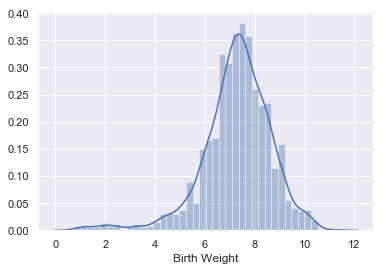

In [11]:
#normal distribution
def normal_distribution(df, column):
    x = df[[column]]
    return sn.distplot(x, axlabel = column)

normal_distribution(data, 'Birth Weight')

Text(0.5, 1.0, 'Boxplot of Birth Weights By Smoker Type')

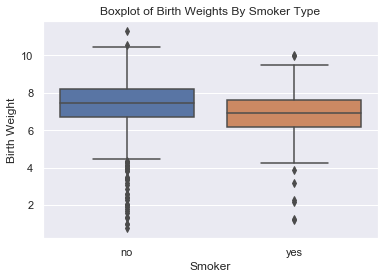

In [12]:
#boxplot
sn.boxplot(x="Smoker", y="Birth Weight", data=data).set_title("Boxplot of Birth Weights By Smoker Type")

Running: Mom Age
Running: Weight Gained
Running: Weeks


<Figure size 432x288 with 0 Axes>

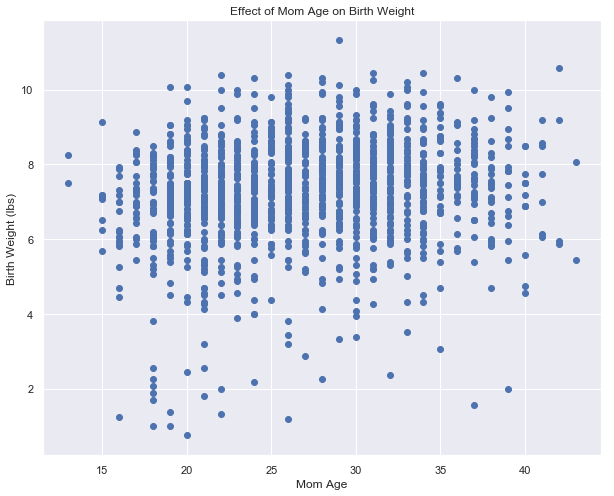

<Figure size 432x288 with 0 Axes>

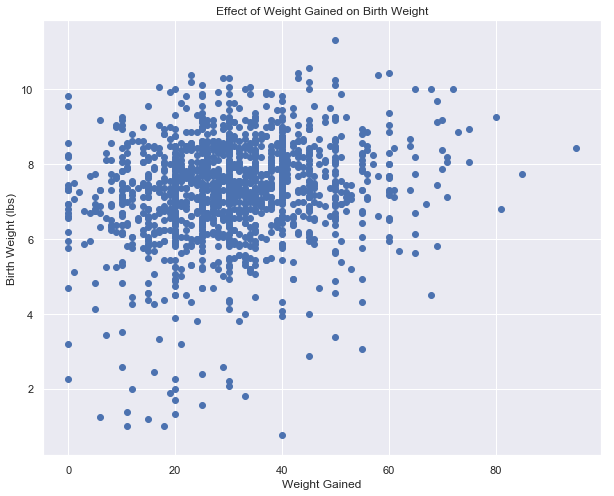

<Figure size 432x288 with 0 Axes>

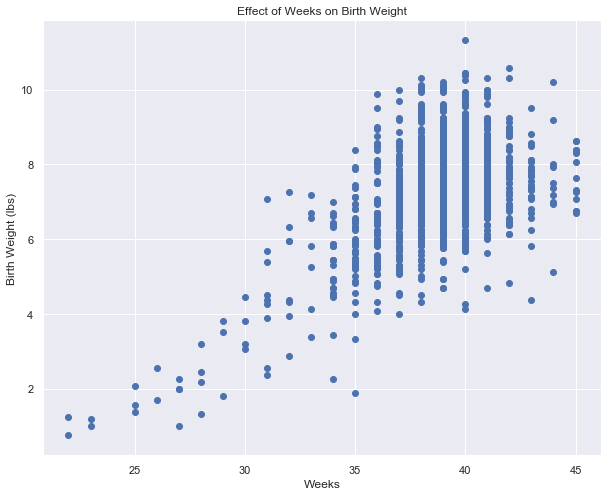

In [13]:
pdf = matplotlib.backends.backend_pdf.PdfPages("scatterplots.pdf")

scatter_columns = ['Mom Age', 'Weight Gained', 'Weeks']

for i in scatter_columns:
    print("Running: {}".format(i))
    plot2 = plt.figure()
    plt.figure(figsize=(10,8))
    plt.title("Effect of {} on Birth Weight".format(i))
    plt.xlabel(i)
    plt.ylabel('Birth Weight ({})'.format('lbs'))
    plt.scatter(data[i], data['Birth Weight'])
    pdf.savefig(plot2)
    
pdf.close()

In [14]:
#Correlation matrix
def corrmatrix(df):
    corrMatrix = df.corr()
    return corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

corrmatrix(data)

,Plural,Sex,Mom Age,Weeks,Marital,Weight Gained,Smoke,BirthWeightOz,Low,Premie,Birth Weight
Plural,1,-0.0066,0.08,-0.33,-0.034,0.094,-0.054,-0.34,0.38,0.3,-0.34
Sex,-0.0066,1,0.019,0.051,-0.011,-0.0084,-0.007,-0.048,-0.027,-0.028,-0.048
Mom Age,0.08,0.019,1,0.037,-0.47,0.01,-0.11,0.15,-0.071,-0.063,0.15
Weeks,-0.33,0.051,0.037,1,-0.064,0.06,-0.032,0.59,-0.53,-0.71,0.59
Marital,-0.034,-0.011,-0.47,-0.064,1,-0.031,0.16,-0.17,0.086,0.096,-0.17
Weight Gained,0.094,-0.0084,0.01,0.06,-0.031,1,0.003,0.19,-0.1,-0.034,0.19
Smoke,-0.054,-0.007,-0.11,-0.032,0.16,0.003,1,-0.13,0.062,0.039,-0.13
BirthWeightOz,-0.34,-0.048,0.15,0.59,-0.17,0.19,-0.13,1,-0.67,-0.5,1
Low,0.38,-0.027,-0.071,-0.53,0.086,-0.1,0.062,-0.67,1,0.5,-0.67
Premie,0.3,-0.028,-0.063,-0.71,0.096,-0.034,0.039,-0.5,0.5,1,-0.5


### Setup and Run Model

In [15]:
categoricals = ['Gender', 'Marital Status', 'Smoker']
include_columns = ['Weeks', 'Gender', 'Marital Status', 'Smoker', 'Birth Weight', 'Mom Age', 'Weight Gained']
y_column = ['Birth Weight']

#split train and test dataset
def train_test_split(df, data_columns, column, cat_columns):
    df2 = df.copy()
    df2 = df2[data_columns]
    df2 = shuffle(df2, random_state=5)
    df2 = sm.add_constant(df2)
    train_data = df2[:int((len(df2)+1)*.80)]
    test_data = df2[int(len(df2)*.80+1):]
    x_train = train_data.drop(column, axis=1)
    x_train = pd.get_dummies(x_train, columns = cat_columns, drop_first=True)
    x_test = test_data.drop(column, axis=1)
    x_test = pd.get_dummies(x_test, columns = cat_columns, drop_first=True)
    y_train = train_data[column]
    y_test = test_data[column]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(data, include_columns, y_column, categoricals)
print(len(x_train))
print(len(x_test))

1128
281


C:\Users\nickp\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
#function to create an OLS regression Model using statsmodels package
def create_ols_model(x, y):
    lr = sm.OLS(np.log(np.ravel(y)), x)
    model = lr.fit()
    return model

In [17]:
ols_model = create_ols_model(x_train, y_train)
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     170.4
Date:                Thu, 02 Jul 2020   Prob (F-statistic):          6.03e-154
Time:                        13:22:17   Log-Likelihood:                 342.32
No. Observations:                1128   AIC:                            -670.6
Df Residuals:                    1121   BIC:                            -635.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.5112      0.084     -6.080      0.000      -0.676      -0.346
Weeks                          0.0600      0.002     29.677      0.000       0.056       0.064
Mom Age                        0.0031      0.001      3.030      0.002       0.001       0.005
Weight Gained                  0.0024      0.000      6.158      0.000       0.002       0.003
Gender_male                    0.0338      0.011      3.160      0.002       0.013       0.055
Marital Status_not married    -0.0323      0.013     -2.496      0.013      -0.058      -0.007
Smoker_yes                    -0.0506      0.015     -3.327      0.001      -0.080      -0.021
==============================================================================
Omnibus:                      276.988   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              965.027
Skew:                          -1.165   Prob(JB):                    2.80e-210
Kurtosis:                       6.886   Cond. No.                         894.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#calculate vif scores
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif["features"] = x_train.columns
vif

,VIF Factor,features
0,248.341963,const
1,1.010450,Weeks
2,1.313463,Mom Age
3,1.004637,Weight Gained
4,1.004998,Gender_male
5,1.331201,Marital Status_not married
6,1.024983,Smoker_yes


In [19]:
#Calculate metrics for Regression Model
def regression_metrics(model, xtest, y_true, xtrain): 
    predictions = model.predict(xtest)
    predictions = np.exp(predictions)
    y_true = np.ravel(y_true)
    dof_ratio = len(xtrain) / len(xtrain.columns)
    mape = np.mean(np.abs((y_true - predictions) / y_true)) * 100
    mse = np.mean((y_true - predictions) ** 2)
    rmse = np.sqrt(np.mean((y_true - predictions) ** 2))
    return mape, mse, rmse, dof_ratio

mape, mse, rmse, dof_ratio = regression_metrics(ols_model, x_test, y_test, x_train)
print('MAPE: {}'.format(mape))
print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))
print('DOF Ratio: {}'.format(dof_ratio))

MAPE: 14.450629941731464
MSE: 1.3346141628692312
RMSE: 1.1552550207072165
DOF Ratio: 161.14285714285714
